In [1]:
import Pkg;
Pkg.add("DifferentialEquations")
Pkg.add("FFTW")
Pkg.add("GLMakie")
Pkg.add("Plots")
using DifferentialEquations, FFTW, GLMakie, Plots, Base.Threads

   Resolving package versions...
   Installed HypergeometricFunctions ───────────── v0.3.27
   Installed OrdinaryDiffEqRosenbrock ──────────── v1.6.0
   Installed BoundaryValueDiffEqFIRK ───────────── v1.5.0
   Installed FastGaussQuadrature ───────────────── v1.0.2
   Installed Accessors ─────────────────────────── v0.1.41
   Installed AlmostBlockDiagonals ──────────────── v0.1.10
   Installed TimerOutputs ──────────────────────── v0.5.27
   Installed StaticArrays ──────────────────────── v1.9.12
   Installed OrdinaryDiffEqSDIRK ───────────────── v1.2.0
   Installed SciMLJacobianOperators ────────────── v0.1.1
   Installed PDMats ────────────────────────────── v0.11.32
   Installed Sundials_jll ──────────────────────── v5.2.3+0
   Installed OrdinaryDiffEqCore ────────────────── v1.18.1
   Installed Statistics ────────────────────────── v1.11.1
   Installed RecursiveArrayTools ───────────────── v3.29.0
   Installed NonlinearSolve ────────────────────── v4.4.0
   Installed BoundaryValueD

In [3]:
Threads.nthreads()

8

In [5]:
# シミュレーションのパラメータ
Nl = 32;  # 格子点数
L = 10.0;  # 系のサイズ
dx = L / Nl;  # 格子間隔
dt = 0.01;  # 時間ステップ
m² = 1.0;  # 質量パラメータ
tf = 10;
n_steps = tf/dt  # シミュレーションのステップ数

1000.0

In [7]:
# 初期条件
X = [exp(- ((i-Nl/2)^2 + (j-Nl/2)^2 + (k-Nl/2)^2)/(2*(Nl/10)^2)) for i=1:Nl, j=1:Nl, k=1:Nl];  # 乱数で初期化
P = zeros(Nl, Nl, Nl);  # 共役運動量（速度）

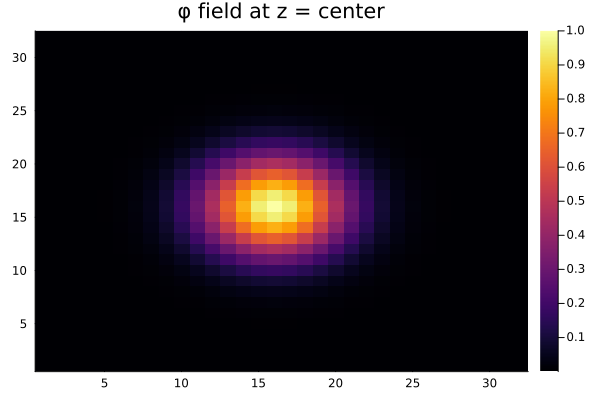

In [9]:
# 初期条件の可視化（中央断面の 2D ヒートマップ）
Plots.heatmap(X[:, :, div(Nl,2)], title="φ field at z = center")

In [9]:
# ラプラシアンの計算（3次元）
function laplacian3D(X, dx)
    return (circshift(X, (1,0,0)) + circshift(X, (-1,0,0)) +
            circshift(X, (0,1,0)) + circshift(X, (0,-1,0)) +
            circshift(X, (0,0,1)) + circshift(X, (0,0,-1)) - 6X) / dx^2
end;

In [11]:
# 3D ラプラシアン（並列化）
function laplacian3D(X, dx)
    Nx, Ny, Nz = size(X)
    ΔX = similar(X)
    @threads for x in 2:Nx-1 
        for y in 2:Ny-1, z in 2:Nz-1
            ΔX[x, y, z] = (X[x+1, y, z] + X[x-1, y, z] +
                           X[x, y+1, z] + X[x, y-1, z] +
                           X[x, y, z+1] + X[x, y, z-1] - 6X[x, y, z]) / dx^2
        end
    end
    return ΔX
end;

In [13]:
# GLMakie の 3D プロット設定
fig = Figure(; size=(600, 600))
ax = Axis3(fig[1,1], title="3D Klein-Gordon Evolution")
X_obs = Observable(X)  # Observable を使用
#vol = volume!(ax, X_obs, algorithm=:iso, isorange=0.1);  # 等値面を描画
vol = volume!(ax, X_obs, colormap=:inferno, transparency=true);

In [15]:
# GIF の作成
@time record(fig, "klein_gordon_3d.gif", 1:n_steps; framerate=10) do i
    global X, P  # 明示的にグローバル変数を指定
    X_new = X .+ dt .* P
    P_new = P .+ dt .* (laplacian3D(X, dx) .- m² .* X)
    X, P = X_new, P_new  # 更新
    X_obs[] = X  # Observable を更新
end;

 60.228898 seconds (29.37 M allocations: 2.344 GiB, 0.59% gc time, 16.68% compilation time: 56% of which was recompilation)
